# Data 시작 onset부터 자르기

In [ ]:
SR = 44100

In [ ]:
import essentia
from essentia.standard import MonoLoader, OnsetDetection, Windowing, FFT, CartesianToPolar, FrameGenerator, Onsets, AudioOnsetsMarker, StereoMuxer, AudioWriter
from tempfile import TemporaryDirectory

# first onset detection function
def onset_detect(input_path):
  # Load audio file.
  audio = MonoLoader(filename=input_path)()

  # 1. Compute the onset detection function (ODF).

  # The OnsetDetection algorithm provides various ODFs.
  od_hfc = OnsetDetection(method='hfc')
  od_complex = OnsetDetection(method='complex')

  # We need the auxilary algorithms to compute magnitude and phase.
  w = Windowing(type='hann')
  fft = FFT() # Outputs a complex FFT vector.
  c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

  # Compute both ODF frame by frame. Store results to a Pool.
  pool = essentia.Pool()
  for frame in FrameGenerator(audio, frameSize=1024, hopSize=512):
      magnitude, phase = c2p(fft(w(frame)))
      pool.add('odf.hfc', od_hfc(magnitude, phase))
      pool.add('odf.complex', od_complex(magnitude, phase))

  # 2. Detect onset locations.
  onsets = Onsets()

  onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                      essentia.array([pool['odf.hfc']]),
                      # You need to specify weights, but if we use only one ODF
                      # it doesn't actually matter which weight to give it
                      [1])

  onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])

  # first onset 이 2초 이상인 것을 우선시
  if onsets_hfc[0] >= 2:
    return onsets_hfc[0]
  return onsets_complex[0]

In [ ]:
# trimmed audio
def audio_trim_per_onset(audio, first_onset, sr=SR):
  start = (int)(first_onset * sr)
  trimmed = audio[start:]
  return trimmed

In [ ]:
import scipy.io.wavfile

# trimmed audio -> wav file write
def write_trimmed_audio(root_path, name, trimmed_audio):
  # exist or not
  if not os.path.exists(root_path):
    # if the demo_folder directory is not present
    # then create it.
    os.makedirs(root_path)
  scipy.io.wavfile.write(f'{root_path}/{name}.wav', SR, trimmed_audio)

In [ ]:
import os
import librosa

# load audio & trimmed per onset
# [pattern, per_drum]
# per_drum: [1_HH, 2_RC, ...], pattern: [P1, P2, ...]
# 04, 08, 16
def main(root_path, trim_path):
  datas = os.listdir(root_path)

  check = False
  for d in datas:
    if d.endswith('.m4a'):
      check = True
      wav = os.path.join(root_path, d)
      print(wav)

      # detect onsets
      onsets = onset_detect(wav)
      # print(onsets)

      # trimming audio
      audio, sr = librosa.load(wav, sr=SR)
      trimmed_audios = audio_trim_per_onset(audio, onsets, sr)
      # print(trimmed_audios)

      # new_file write
      name = d[:-4]
      write_trimmed_audio(trim_path, name, trimmed_audios)
    elif d.endswith('.txt') == False:
      new_root_path = os.path.join(root_path, d)
      new_trim_path = os.path.join(trim_path, d)
      main(new_root_path, new_trim_path)

In [ ]:
# 드럼 녹음 data path
input_file_path = ""
root_path = "/content/drive/MyDrive/Colab Notebooks/data" + input_file_path
trim_path = "/content/drive/MyDrive/Colab Notebooks/sequence_data" + input_file_path
main(root_path, trim_path)

# 데이터 라벨링

In [ ]:
!pip install numpy

In [ ]:
"""
CC : 0
HH : 1
KK : 7
SD : 5
"""

drum2code = {'CC':0, 'HH':1, 'KK':7, 'SD':5}
code2drum = {0:'CC', 1:'HH', 7:'KK', 5:'SD'}

In [ ]:
DRUM = 0

In [ ]:
import os
import numpy as np

data_root_path = f"/content/drive/MyDrive/Colab Notebooks/sequence_data/per_drum/{DRUM}_{code2drum[DRUM]}"
beat_folders = os.listdir(data_root_path)

X_data_full = []
for beat in beat_folders:
  X_data_full += [os.path.join(data_root_path, beat, file) for file in os.listdir(os.path.join(data_root_path, beat))]

X_data_full

### onset detect function

In [ ]:
import essentia
from essentia.standard import MonoLoader, OnsetDetection, Windowing, FFT, CartesianToPolar, FrameGenerator, Onsets, AudioOnsetsMarker, StereoMuxer, AudioWriter
from tempfile import TemporaryDirectory

# onset detection function
def onset_detect(input_path):
  # Load audio file.
  audio = MonoLoader(filename=input_path)()

  # 1. Compute the onset detection function (ODF).

  # The OnsetDetection algorithm provides various ODFs.
  od_hfc = OnsetDetection(method='hfc')
  od_complex = OnsetDetection(method='complex')

  # We need the auxilary algorithms to compute magnitude and phase.
  w = Windowing(type='hann')
  fft = FFT() # Outputs a complex FFT vector.
  c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

  # Compute both ODF frame by frame. Store results to a Pool.
  pool = essentia.Pool()
  for frame in FrameGenerator(audio, frameSize=1024, hopSize=512):
      magnitude, phase = c2p(fft(w(frame)))
      pool.add('odf.hfc', od_hfc(magnitude, phase))
      pool.add('odf.complex', od_complex(magnitude, phase))

  # 2. Detect onset locations.
  onsets = Onsets()

  onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                      essentia.array([pool['odf.hfc']]),
                      # You need to specify weights, but if we use only one ODF
                      # it doesn't actually matter which weight to give it
                      [1])

  onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])

  # crush 08 박자 예외처리
  if "CC" in input_path and "08" in input_path:
    return onsets_hfc[:1]
  # crush 04 박자 예외처리
  if "CC" in input_path and "04" in input_path:
    return onsets_hfc[:4]

  # onset 개수가 짝수인 것을 우선
  if len(onsets_hfc) % 2 == 0:
    return onsets_hfc
  elif len(onsets_complex) % 2 == 0:
    return onsets_complex
  elif len(onsets_hfc) > len(onsets_complex):
    return onsets_hfc
  else:
    return onsets_complex

### data labeling

In [ ]:
ONSET_DURATION = 0.1

In [ ]:
TIME_WIDTH = 1024

In [ ]:
N_FFT = 2048
HOP_LENGTH = 512
WIN_LENGTH = 2048

In [ ]:
import librosa

def data_labeling(datas):
  X_data = []
  Y_data = []

  # data load
  for path in datas:
    # load audio wav array
    audio, sr = librosa.load(path, sr=SR)
    print(path)

    # translate STFT
    stft = librosa.stft(y=audio, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, window='hann')
    stft = np.abs(stft, dtype=np.float64)
    if stft.shape[1] < TIME_WIDTH:
      stft_new = np.pad(stft, pad_width=((0,0), (0, TIME_WIDTH - stft.shape[1])), mode='constant')
    else:
      stft_new = stft[:][:TIME_WIDTH]
    stft_new = np.transpose(stft_new)
    X_data.append(stft_new)

    # onset detection & labeling
    # onset position : 1
    # onset position with ONSET_DURATION : 0.5
    # extra : 0
    onsets_arr = onset_detect(path)
    labels = [0.0] * TIME_WIDTH
    print(onsets_arr)
    for onset in onsets_arr:
      soft_start_position = max((onset - ONSET_DURATION), 0) * SR / HOP_LENGTH
      onset_position = onset * SR / HOP_LENGTH
      soft_end_position = (onset + ONSET_DURATION) * SR / HOP_LENGTH
      for i in range((int)(soft_start_position), (int)(soft_end_position)):
        if labels[i] == 1:
          continue
        labels[i] = 0.5
      labels[(int)(onset_position)] = 1

    Y_data.append(labels)

  return np.array(X_data, dtype=np.float64), np.array(Y_data)

In [ ]:
X_data, Y_data = data_labeling(X_data_full[:50])

/content/drive/MyDrive/Colab Notebooks/sequence_data/per_drum/0_CC/08/CC_08_9961.wav
[0.01160998]
/content/drive/MyDrive/Colab Notebooks/sequence_data/per_drum/0_CC/08/CC_08_9977.wav
[0.01160998]
/content/drive/MyDrive/Colab Notebooks/sequence_data/per_drum/0_CC/08/CC_08_9974.wav
[0.01160998]
/content/drive/MyDrive/Colab Notebooks/sequence_data/per_drum/0_CC/08/CC_08_9970.wav
[0.01160998]
/content/drive/MyDrive/Colab Notebooks/sequence_data/per_drum/0_CC/08/CC_08_9980.wav
[0.01160998]
/content/drive/MyDrive/Colab Notebooks/sequence_data/per_drum/0_CC/08/CC_08_9973.wav
[0.01160998]
/content/drive/MyDrive/Colab Notebooks/sequence_data/per_drum/0_CC/08/CC_08_9998.wav
[0.01160998]
/content/drive/MyDrive/Colab Notebooks/sequence_data/per_drum/0_CC/08/CC_08_9950.wav
[0.01160998]
/content/drive/MyDrive/Colab Notebooks/sequence_data/per_drum/0_CC/08/CC_08_9963.wav
[0.01160998]
/content/drive/MyDrive/Colab Notebooks/sequence_data/per_drum/0_CC/08/CC_08_9953.wav
[0.01160998]
/content/drive/MyDri

In [ ]:
Y_data.shape

(50, 1024)

In [ ]:
# split train & test dataset
test_cnt = (int)(X_data.shape[0] * 0.2)

X_train, Y_train = X_data[:-test_cnt], Y_data[:-test_cnt]
X_test, Y_test = X_data[-test_cnt:], Y_data[-test_cnt:]

X_train.shape, Y_train.shape

((40, 1024, 1025), (40, 1024))

In [ ]:
Y_train.dtype

dtype('float64')

In [ ]:
# Y_train reshape
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], 1))

Y_train.shape, Y_test.shape

((8, 1024, 1), (2, 1024, 1))

### STFT 그래프

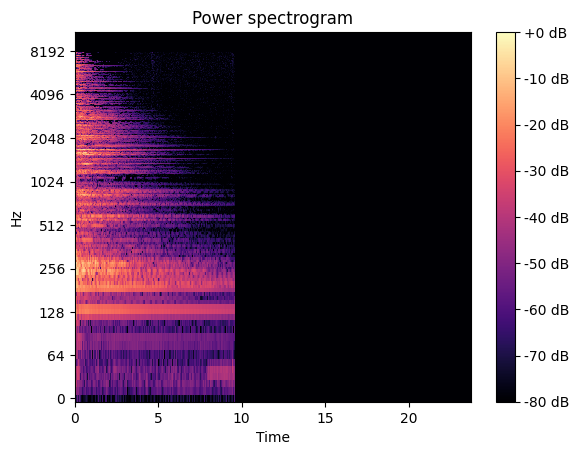

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(X_data[0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

# RNN 모델

In [ ]:
import tensorflow as tf

# build the model
model = tf.keras.Sequential()

# bidirection-RNN layer
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True, input_shape=(TIME_WIDTH, N_FFT // 2 + 1), activation='sigmoid')))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='sigmoid')))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='sigmoid')))

# Flatten layer
model.add(tf.keras.layers.Flatten())

# dense layer
model.add(tf.keras.layers.Dense(TIME_WIDTH, activation='sigmoid'))

model.build((None, TIME_WIDTH, N_FFT // 2 + 1))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 1024, 100)         107600    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 1024, 100)         15100     
 onal)                                                           
                                                                 
 bidirectional_8 (Bidirecti  (None, 1024, 100)         15100     
 onal)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 102400)            0         
                                                                 
 dense_2 (Dense)             (None, 1024)              104858624 
                                                      

In [ ]:
# compile the model
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# train the model
history = model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
2/2 [==============================] - 12s 3s/step - loss: 0.7410 - accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 5s 2s/step - loss: 0.5286 - accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 8s 4s/step - loss: 0.2704 - accuracy: 0.9750
Epoch 4/10
2/2 [==============================] - 6s 2s/step - loss: 0.1208 - accuracy: 0.9750
Epoch 5/10
2/2 [==============================] - 5s 2s/step - loss: 0.0583 - accuracy: 0.9750
Epoch 6/10
2/2 [==============================] - 8s 3s/step - loss: 0.0329 - accuracy: 0.9750
Epoch 7/10
2/2 [==============================] - 5s 2s/step - loss: 0.0215 - accuracy: 0.9750
Epoch 8/10
2/2 [==============================] - 6s 3s/step - loss: 0.0159 - accuracy: 0.9750
Epoch 9/10
2/2 [==============================] - 8s 2s/step - loss: 0.0130 - accuracy: 0.9750
Epoch 10/10
2/2 [==============================] - 6s 2s/step - loss: 0.0113 - accuracy: 0.9750


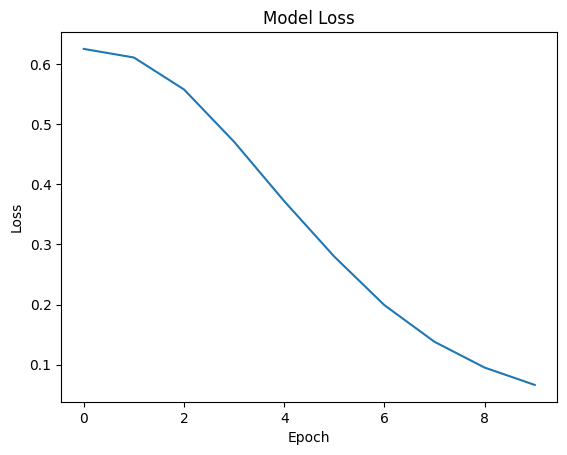

In [ ]:
import matplotlib.pyplot as plt

# plot the loss results
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

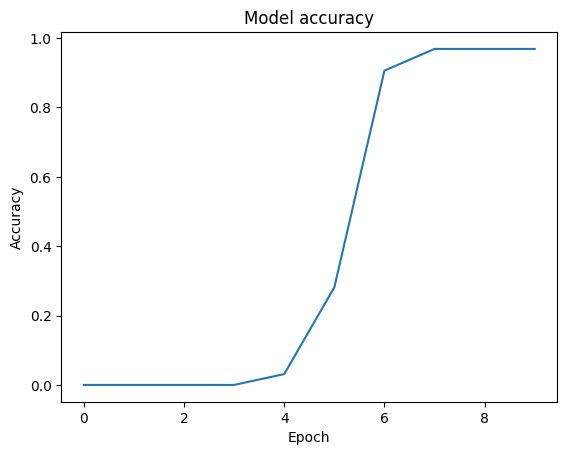

In [ ]:
# plot the accuracy results
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)

1/1 [==============================] - 5s 5s/step - loss: 0.0108 - accuracy: 0.9000


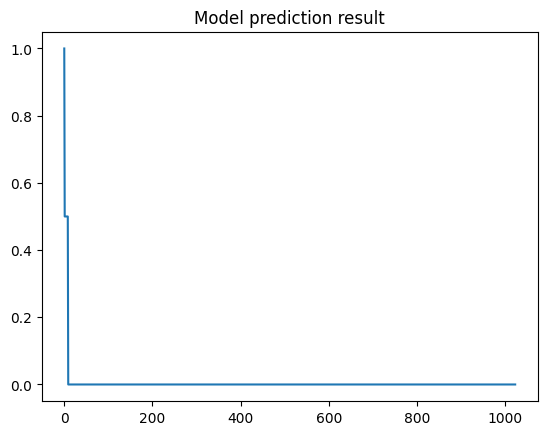

In [ ]:
num = 7
Y_test[num]
plt.plot(Y_test[num])
plt.title('Model prediction result')
plt.show()

(1, 1024, 1025)
1/1 [==============================] - 1s 809ms/step
[[9.8802382e-01 4.8436832e-01 5.0488758e-01 ... 2.2852120e-03
  3.4632210e-03 9.5517439e-04]]


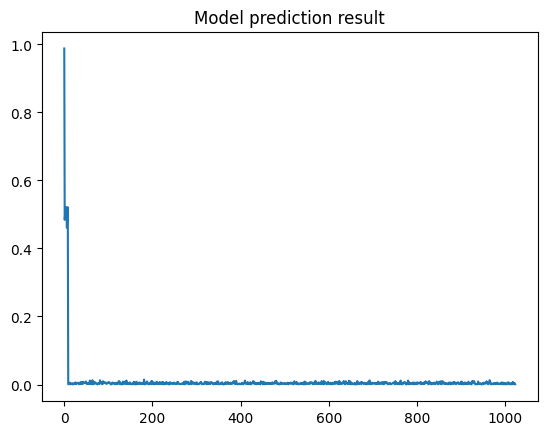

In [ ]:
import matplotlib.pyplot as plt

num = 7
X_predict = X_test[num].reshape((1, X_test[num].shape[0], X_test[num].shape[1]))
print(X_predict.shape)
prediction = model.predict(X_predict)

print(prediction)
plt.plot(prediction[0])
plt.title('Model prediction result')
plt.show()